# Sistema de clasificación de imágenes.

In [ ]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
import shutil
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, models


## Definición del problema

> El objetivo principal de este proyecto es desarrollar un modelo de Aprendizaje Profundo (Deep Learning) capaz de realizar una clasificación entre perros y gatos.

## Recopilación de datos

> Dataset de [dogs vs cats](https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip)

## Configura y detecta el hardware disponible.

In [ ]:
def setup_hardware():
    # Configuramos un logger para que los mensajes se vean más profesionales
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger("HardwareSetup")

    gpus = tf.config.list_physical_devices('GPU')
    
    if gpus:
        try:
            # En NVIDIA esto evita que TF reserve toda la VRAM de golpe
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            logger.info(f"✅ GPU(s) detectada(s): {len(gpus)}. Tipo: {gpus[0].device_type}")
            # Esto ayuda a saber si es DirectML (AMD) o CUDA (NVIDIA)
            details = tf.config.experimental.get_device_details(gpus[0])
            logger.info(f"Detalles del dispositivo: {details.get('device_name', 'Desconocido')}")
            
        except RuntimeError as e:
            logger.error(f"Error al configurar la GPU: {e}")
    else:
        logger.warning("⚠️ No se detectó GPU. El entrenamiento será significativamente más lento en CPU.")

setup_hardware()

INFO:HardwareSetup:✅ GPU(s) detectada(s): 1. Tipo: GPU
INFO:HardwareSetup:Detalles del dispositivo: DML


## Carga del conjunto de datos.

In [ ]:
TRAIN_RATIO = 0.8

#TODAS las imágenes mezcladas
data_dir = "./data/db-dogs-vs-cats"

#Crear estructura de carpetas final
train_cats = os.path.join(data_dir, "train", "cats")
train_dogs = os.path.join(data_dir, "train", "dogs")
test_cats  = os.path.join(data_dir, "test", "cats")
test_dogs  = os.path.join(data_dir, "test", "dogs")

#Lista de las carpetas de destino para verificación
folders_to_check = [train_cats, train_dogs, test_cats, test_dogs]

#VERIFICACIÓN DE ESTADO
#Comprueba si alguna de las carpetas de destino ya contiene archivos
is_data_prepared = any(os.path.exists(folder) and os.listdir(folder) for folder in folders_to_check)

if is_data_prepared:
    print("✅ DATOS LISTOS: Se encontraron archivos en las carpetas de train/test. Saltando la preparación.")
    #Muestra el total actual de entrenamiento (suma de cats + dogs en train)
    total_train = len(os.listdir(train_cats)) + len(os.listdir(train_dogs))
    total_test = len(os.listdir(test_cats)) + len(os.listdir(test_dogs))
    print(f"   Total Entrenamiento: {total_train} imágenes. Total Prueba: {total_test} imágenes.")
else:
    print(f"⏳ DATOS NO PREPARADOS: Iniciando la división con ratio {TRAIN_RATIO}...")

    #Crear las carpetas si no existen
    for folder in folders_to_check:
        os.makedirs(folder, exist_ok=True)

    #Listar y Separar imágenes
    all_images = [img for img in os.listdir(data_dir) if img.endswith(".jpg")]
    
    #Separar TODAS las imágenes por clase
    cat_images = [img for img in all_images if img.lower().startswith("cat")]
    dog_images = [img for img in all_images if img.lower().startswith("dog")]

    def split_and_link(images, train_path, test_path, data_source_dir, train_ratio):
        """Divide todas las imágenes disponibles (len(images)) usando el ratio y crea enlaces simbólicos (rápido)."""
        random.shuffle(images)
        split_idx = int(len(images) * train_ratio)

        train_imgs = images[:split_idx]
        test_imgs  = images[split_idx:]
        
        #Función auxiliar para crear el enlace o usar la copia de respaldo
        def create_link_or_copy(img_name, dest_path):
            source_file = os.path.join(data_source_dir, img_name)
            dest_file = os.path.join(dest_path, img_name)
            
            try:
                #Intentar crear un enlace simbólico (más rápido)
                os.symlink(source_file, dest_file)
            except OSError:
                #Si falla (ej. faltan permisos de administrador en Windows), usar copia (más lento)
                #O si el archivo ya existe
                if not os.path.exists(dest_file):
                    print(f"    [!] Falló symlink para {img_name}. Usando copia. (Requiere Admin para symlinks)")
                    shutil.copy(source_file, dest_file)
        
        #Crear enlaces/copias para el conjunto de entrenamiento
        for img in train_imgs:
            create_link_or_copy(img, train_path)

        #Crear enlaces/copias para el conjunto de prueba
        for img in test_imgs:
            create_link_or_copy(img, test_path)

        print(f"   {os.path.basename(train_path)}: {len(train_imgs)} imágenes (Entrenamiento)")
        print(f"   {os.path.basename(test_path)}: {len(test_imgs)} imágenes (Prueba)\n")

    #Aplicar split para cada clase (usando el TRAIN_RATIO de 0.8)
    split_and_link(cat_images, train_cats, test_cats, data_dir, TRAIN_RATIO)
    split_and_link(dog_images, train_dogs, test_dogs, data_dir, TRAIN_RATIO)

✅ DATOS LISTOS: Se encontraron archivos en las carpetas de train/test. Saltando la preparación.
   Total Entrenamiento: 20000 imágenes. Total Prueba: 5000 imágenes.


In [ ]:
# Paths to training data
train_path = os.path.join(data_dir, "train")
dogs_dir = os.path.join(train_path, "dogs")
cats_dir = os.path.join(train_path, "cats")

##  Visualización de la información de entrada.

In [ ]:
# Function to display first 9 images of a class
def show_images(img_folder, title):
    plt.figure(figsize=(8,8))
    images = os.listdir(img_folder)[:9]
    for i, img_name in enumerate(images):
        img_path = os.path.join(img_folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)

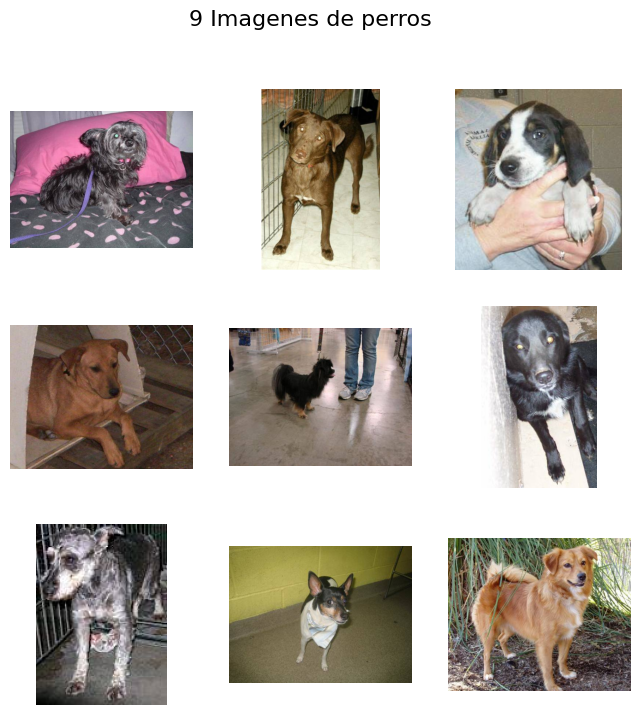

In [ ]:
show_images(dogs_dir, "9 Imagenes de perros")

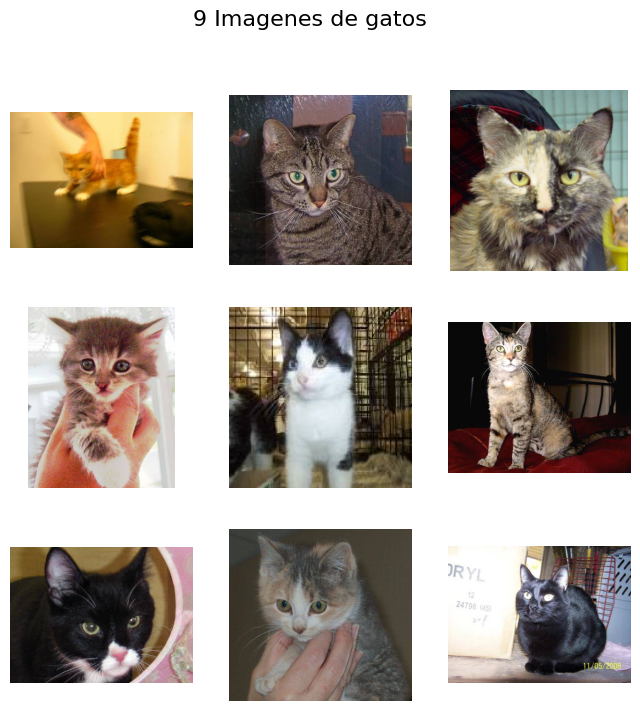

In [ ]:
show_images(cats_dir, "9 Imagenes de gatos")

## Dimsensionar imagenes y pipeline de entrenamiento.

In [ ]:
train_dir = "data/db-dogs-vs-cats/train"
test_dir = "data/db-dogs-vs-cats/test"

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 
image_size = (200, 200)

def load_and_preprocess(path):
    # La CPU lee y decodifica en paralelo
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image /= 255.0  # Normalización (equivalente al rescale=1./255)

    # Extraer etiqueta del nombre de la carpeta
    parts = tf.strings.split(path, os.path.sep)
    label = tf.cast(parts[-2] == "dogs", tf.int32) # 1 para perros, 0 para gatos
    return image, label

# Crear el pipeline de entrenamiento
train_files = tf.data.Dataset.list_files(train_dir + "/*/*.jpg")
train_ds = train_files.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)

# Crear el pipeline de prueba
test_files = tf.data.Dataset.list_files(test_dir + "/*/*.jpg")
test_ds = test_files.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

## Modelo de Red Neuronal Convolucional (CNN).

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=(200, 200, 3)),
    data_augmentation,

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 128)     

#### Obervaciones:

> - Incremento de Filtros: Vas aumentando la profundidad de la red (64 / 128 / 256 filtros).
> - Total de parámetros: Tienes 27.9 millones.
> - Incluye 1,920 parámetros no entrenables, los cuales corresponden a las medias y varianzas calculadas por las capas de normalización.

### Compilar el modelo.

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"])

### Guarda el modelo.

In [ ]:
#Guarda el modelo cada vez que el 'val_loss' (pérdida de validación) mejore.
checkpoint = ModelCheckpoint(
    './models/best_model_dogs_vs_cats.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
#Detendrá el entrenamiento si el 'val_loss' no mejora después de un número de épocas.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

#Combinar los Callbacks
callbacks_list = [checkpoint, early_stopping]

> Paso la lista al parámetro callbacks en el método model.fit() que es la forma moderna y recomendada en lugar de fit_generator.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,                         
    callbacks=callbacks_list
)

Epoch 1/10


625/625 [==============================] - ETA: 0s - loss: 2.4376 - accuracy: 0.5416
Epoch 1: val_loss improved from inf to 0.65389, saving model to ./models\best_model_dogs_vs_cats.keras
625/625 [==============================] - 326s 516ms/step - loss: 2.4376 - accuracy: 0.5416 - val_loss: 0.6539 - val_accuracy: 0.6020
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6403
Epoch 2: val_loss improved from 0.65389 to 0.63723, saving model to ./models\best_model_dogs_vs_cats.keras
625/625 [==============================] - 311s 498ms/step - loss: 0.6567 - accuracy: 0.6403 - val_loss: 0.6372 - val_accuracy: 0.6326
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.6890
Epoch 3: val_loss improved from 0.63723 to 0.59788, saving model to ./models\best_model_dogs_vs_cats.keras
625/625 [==============================] - 313s 501ms/step - loss: 0.5889 - accuracy: 0.6890 - val_loss: 0.5979 - val_accuracy: 0.6610
E

#### Observaciones:
> - El Rendimiento es Sólido (89.7% de Accuracy).
> - La pérdida de validación bajó de 0.6539 en la época 1 a 0.2498 en la época 10.
> - El modelo aprendió de forma estable y constante.
> - Los avisos de while_loop que salen informan que el aumento de datos se está haciendo en la CPU de forma un poco ineficiente.

### Visualización de la evaluación del entrenamiento Y prueba.

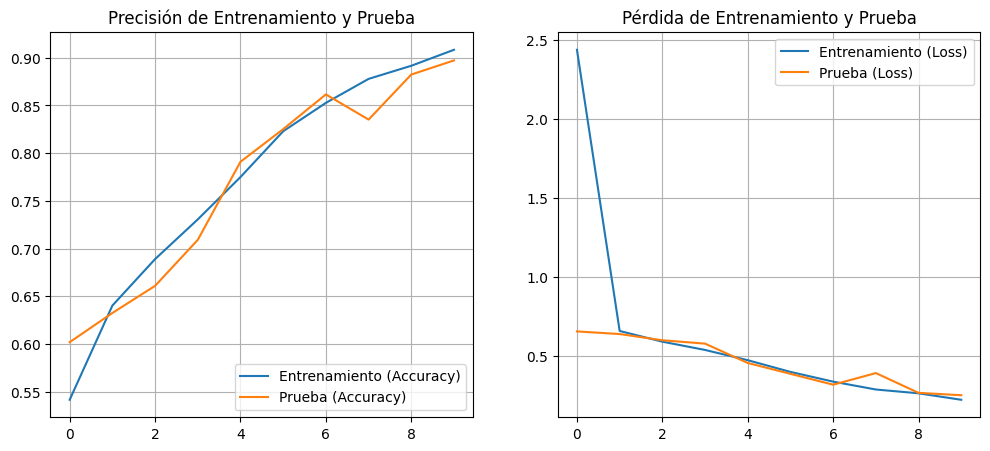

In [ ]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Gráfica de Precisión (ACCURACY)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento (Accuracy)')
    plt.plot(epochs_range, val_acc, label='Prueba (Accuracy)')
    plt.title('Precisión de Entrenamiento y Prueba')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Gráfica de Pérdida (LOSS)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento (Loss)')
    plt.plot(epochs_range, val_loss, label='Prueba (Loss)')
    plt.title('Pérdida de Entrenamiento y Prueba')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

plot_training_results(history)


#### Observaciones:
> - Precisión: Ha alcanzado casi un 90% de precisión en el conjunto de prueba en 10 épocas.
> - Las curvas son sincronizadas esto es la señal de un modelo sano.
> - Caída de Pérdida (Loss): La gráfica de la derecha muestra una caída drástica al principio y luego se estabiliza. El modelo corrige sus errores más grandes rápidamente y luego se dedica a pulir los detalles.

 ### Carga el mejor modelo y utiliza el conjunto de test para hacer predicciones.

In [ ]:
try:
    best_model = load_model('models/best_model_dogs_vs_cats.keras')
    print("Modelo cargado exitosamente.")
except:
    print("Error al cargar el modelo. Asegúrate de que 'best_model_dogs_vs_cats.keras' exista.")

Modelo cargado exitosamente.


Precisión del modelo en general sobre el conjunto de prueba.

In [ ]:
loss, acc = best_model.evaluate(test_ds)
print(f"\nResultados de Evaluación en el conjunto de Prueba:")
print(f"Pérdida (Loss): {loss:.4f}")
print(f"Precisión (Accuracy): {acc:.4f}")

157/157 [==============================] - 20s 121ms/step - loss: 0.2498 - accuracy: 0.8972

Resultados de Evaluación en el conjunto de Prueba:
Pérdida (Loss): 0.2498
Precisión (Accuracy): 0.8972


### Predicciones

In [ ]:
predictions = best_model.predict(test_ds)

157/157 [==============================] - 18s 112ms/step


In [ ]:
# Para obtener las clases finales (0 o 1), aplico un threshold de 0.5
print("\nPrimeras 10 Clases Predichas (0 o 1):")
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes[:10].flatten()


Primeras 10 Clases Predichas (0 o 1):


array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0])

In [ ]:
# Obtener etiquetas reales
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = (predictions > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=['Gato', 'Perro']))

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# 5. Visualizarla de forma profesional
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Gato', 'Perro'], 
            yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión: Perros vs Gatos')
plt.show()

Ejecutando predicciones en la GPU...
157/157 [==============================] - 5s 32ms/step
--- MOSTRANDO 8 IMAGENES ALEATORIAS ---


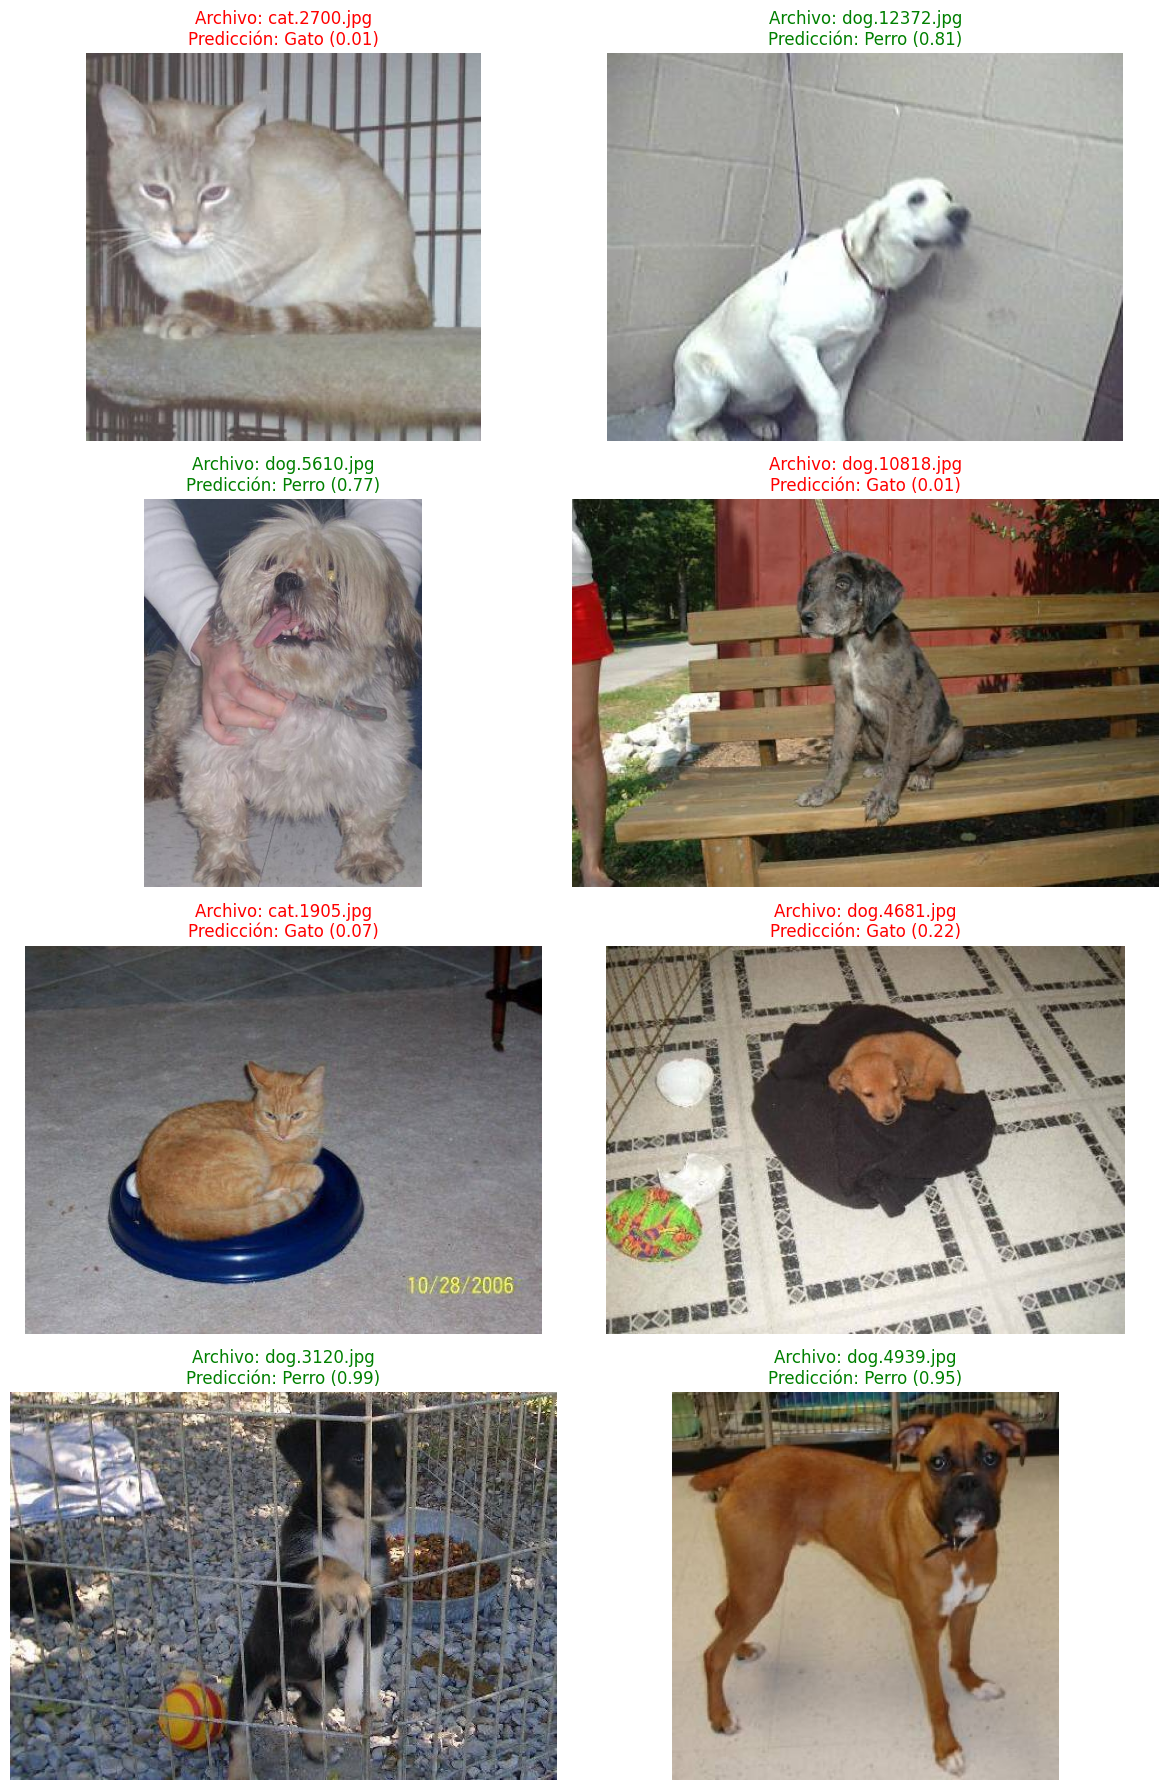

In [ ]:
#El codigo visualiza imagenes aleatorias del conjunto de prueba junto con sus predicciones.

#Convertimos el dataset de rutas a una lista de Python para poder usar índices aleatorios.
rutas_completas = [path.numpy().decode('utf-8') for path in test_files]

#Ejecutar predicciones sobre todo el conjunto de prueba
print("Ejecutando predicciones en la GPU...")
predictions = model.predict(test_ds)

NUM_A_MOSTRAR = 8
clases = {0: "Gato", 1: "Perro"}

#Genera 8 índices únicos y aleatorios
total_imagenes = len(rutas_completas)
indices_aleatorios = np.random.choice(total_imagenes, size=NUM_A_MOSTRAR, replace=False)

#Extraer los datos correspondientes a esos índices
rutas_8_imagenes = [rutas_completas[i] for i in indices_aleatorios]
predictions_8 = predictions[indices_aleatorios].flatten() 
clases_predichas_8 = (predictions_8 > 0.5).astype(int)



#GENERA LA VISUALIZACIÓN
fig, axes = plt.subplots(4, 2, figsize=(12, 18))
axes = axes.flatten()

print(f"--- MOSTRANDO {NUM_A_MOSTRAR} IMAGENES ALEATORIAS ---")

for i in range(NUM_A_MOSTRAR):
    #Obtener información
    ruta_completa = rutas_8_imagenes[i]
    nombre_archivo = os.path.basename(ruta_completa) # Solo el nombre para el título
    probabilidad = predictions_8[i]
    clase_predicha = clases_predichas_8[i]
    etiqueta = clases[clase_predicha]
    
    #Cargar la imagen directamente desde la ruta completa
    try:
        img = tf.keras.utils.load_img(ruta_completa)
    except Exception as e:
        print(f"Error al cargar {ruta_completa}: {e}")
        continue

    #Mostrar la imagen y el resultado
    ax = axes[i]
    ax.imshow(img)
    
    color_titulo = 'green' if clase_predicha == 1 else 'red'
    
    title_text = f"Archivo: {nombre_archivo}\nPredicción: {etiqueta} ({probabilidad:.2f})"
    ax.set_title(title_text, fontsize=12, color=color_titulo)
    ax.axis('off') 

plt.tight_layout()


#### Observaciones:
> - Aciertos con alta confianza: En casos como el `dog.3120.jpg` o `dog.4939.jpg`, el modelo tiene una confianza casi total (0.99 y 0.95)
> - Fallos: El modelo se equivocó en `dog.10818.jpg` y `dog.4681.jpg` clasificándolos como gatos.

### Conclusiones:
> - El modelo no sufrió de overfitting (sobreajuste). Esto significa que el "cerebro" de la IA realmente aprendió a distinguir rasgos físicos de perros y gatos en lugar de simplemente memorizar las fotos de entrenamiento.